# Matching Scene Labels to Image Pairs

This notebook explores how the BDD100K dataset can bundle scene information together with the images. 

I am performing semantic segmentation on the 10K version of the dataset but only the 100K version (video clips) is provided with secene labels. The 10K version is a subset with images from the videos of the 100K version - Hence the hypothesis is that I should be able to retrieve scene information from the video clips and assign that info to each image in the 10K version. This is not something that the dataset is intended on, so there is no easy way to retrieve scene information on the semantic segmentation dataset.

## Loading Detection Meta Information
Here I load the detection JSON files (`det_train.json` and `det_val.json` from the `det_20` folder). These detection files contain meta information such as the scene (frame attributes) each video was taken in.

Possible scenes according to the [documentation of BDD100K](https://doc.bdd100k.com/format.html#:~:text=scene%3A%20%22tunnel%7Cresidential%7Cparking%20lot%7Cundefined%7Ccity%20street%7Cgas%20stations%7Chighway%7C%22) are the following:
- tunnel
- residential
- parking lot
- undefined
- city street
- gas stations
- highway

In [2]:
import json

with open('./data/bdd100k/labels/det_20/det_train.json') as f:
    train_data = json.load(f)
    
with open('./data/bdd100k/labels/det_20/det_val.json') as f:
    val_data = json.load(f)

Then I am loading the filenames of each image from both the `val` and `train` partition into memory.

*Note*: I am only using the `train` and `val` partition since the `test` partition does not contain segmentation ground truths, thus, it would be useless in my context.

In [3]:
import os 

train_image_files = os.listdir('./data/bdd100k/images/10k/train')
val_image_files = os.listdir('./data/bdd100k/images/10k/val')

print('--- Train Data ---')
print(f'# Entries in Detection JSON: {len(train_data)}')
print(f'# Images: {len(train_image_files)}\n')

print('--- Validation Data ---')
print(f'# Entries in Detection JSON: {len(val_data)}')
print(f'# Images: {len(val_image_files)}\n')

--- Train Data ---
# Entries in Detection JSON: 69863
# Images: 7000

--- Validation Data ---
# Entries in Detection JSON: 10000
# Images: 1000



The output shows that the meta information JSON files have much more entries than the images I am working with. This stems from the fact that, as mentioned before, the meta information stems from the 100K subset where each frame of the video has such attributes.

## Looking for Matches
When inspecting [`det_val.json`](./data/bdd100k/labels/det_20/det_val.json) or [`det_train.json`](./data/bdd100k/labels/det_20/det_train.json), one can see that each JSON entry has a key which corresponds to some `.jpg`-filename. I am therefore trying to match that filename to an image filename in the 10K version I have downloaded:

In [4]:
from tqdm import tqdm

val_matches = []
train_matches = []

n_val_images = 0
n_train_images = 0

for det in tqdm(val_data, desc="Processing Validation data"):
    if det.get('name') in train_image_files:
        n_train_images += 1
        val_matches.append((det.get("name"), det.get("attributes").get("scene")))
    if det.get('name') in val_image_files:
        n_val_images += 1
        val_matches.append((det.get("name"), det.get("attributes").get("scene")))    

for det in tqdm(train_data, desc="Processing Training data"):
    if det.get('name') in train_image_files:
        n_train_images += 1
        train_matches.append((det, det.get("attributes").get("scene")))
    if det.get('name') in val_image_files:
        n_val_images += 1
        val_matches.append((det.get("name"), det.get("attributes").get("scene")))
        
print(f'\nNumber of matches found for images in validation: {n_val_images} (of {len(val_matches)})')
print(f'Number of matches found for images in training data: {n_train_images} (of {len(train_matches)})')

Processing Validation data:   0%|          | 0/10000 [00:00<?, ?it/s]

Processing Training data: 100%|██████████| 69863/69863 [00:07<00:00, 8829.00it/s] 


Number of matches found for images in validation: 0 (of 454)
Number of matches found for images in training data: 3426 (of 2972)


The interesting observation here is that there are **no images in my validation pre-partition that have a corresponding scene label**  but for 454 validation meta attributes there exists a match in my train images.

This means the BDD100K research team seemingly did not sample the validation subset in the 10K version from the videos in the 100K version; Thus, I will only be able to use the pre-partitioned `train` subset for my challenge.

## Getting an Overview of Scenes
Next I will take a quick look at the number of occurences for each scene so I can make out if I have enough samples of each scene to answer my research question.

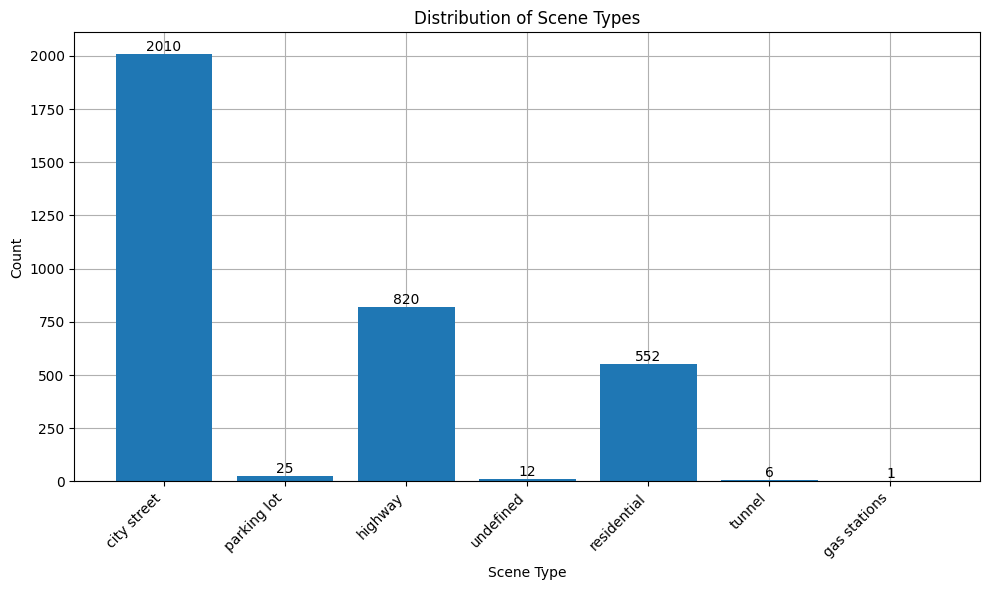

In [5]:
import matplotlib.pyplot as plt

scene_counts = {}
for match in train_matches + val_matches:
    scene = match[1]
    if scene in scene_counts:
        scene_counts[scene] += 1
    else:
        scene_counts[scene] = 1

plt.figure(figsize=(10,6))
plt.bar(scene_counts.keys(), scene_counts.values(), zorder=2)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Scene Types')
plt.grid(True, zorder=1)
plt.xlabel('Scene Type')
plt.ylabel('Count')

for i, v in enumerate(scene_counts.values()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

The number of scenes in a `city street` environment clearly dominate the other scenes. The `parking lot`, `tunnel` and `gas stations` scenes are quite underrepresented. Most "non-city" scenes can be attributed to either `highway` or `residential`.

### Statistical Testing
Here I defined a function that will perform Power Analysis with the Chi-Square Goodness-of-Fit test to see how significantly each class may deviate from a uniform distribution. Additionally, I print out a Proportions Z-Test for each class to conduct individual proportion and see which class' proportion is significantly lower than a defined threshold. I mainly decided to implement these tests to underline the observations we have seen in the previous section.

In [13]:
import numpy as np
from statsmodels.stats.power import GofChisquarePower
from prettytable import PrettyTable
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.api as sm

def test_statistics(class_counts, alpha=0.05, power=None, total_samples=None):
    """
    Performs power analysis for multi-class classification using chi-square goodness-of-fit test
    and identifies underrepresented classes through post-hoc analyses.
    
    Parameters:
    - class_counts (dict): Dictionary with class labels as keys and sample counts as values.
    - alpha (float): Significance level. Default is 0.05.
    - power (float): Desired power level (1 - beta). If None, power is calculated.
    - total_samples (int): Total sample size. If None, uses sum of class_counts.
    
    Returns:
    - None. Prints the power analysis and post-hoc results.
    """
    if not isinstance(class_counts, dict) or len(class_counts) < 2:
        raise ValueError("class_counts must be a dictionary with at least two classes.")
    
    classes = list(class_counts.keys())
    
    if total_samples is None:
        total_samples = sum(class_counts.values())
    else:
        if total_samples < sum(class_counts.values()):
            raise ValueError("total_samples cannot be less than the sum of class_counts.")
    
    observed_counts = np.array([class_counts[cls] for cls in classes])
    observed_proportions = observed_counts / sum(observed_counts)
    
    num_classes = len(classes)
    expected_proportions = np.array([1/num_classes] * num_classes)
    
    w = np.sqrt(np.sum((observed_proportions - expected_proportions)**2 / expected_proportions))
    
    power_analysis = GofChisquarePower()
    
    if power is None:
        calculated_power = power_analysis.power(effect_size=w, nobs=total_samples, alpha=alpha)
    else:
        required_n = power_analysis.solve_power(effect_size=w, power=power, alpha=alpha)
    
    table = PrettyTable()
    table.field_names = ["Class", "Sample Count", "Observed Proportion", "Expected Proportion", "Contribution to w²", "Std Residual"]
    
    contributions = (observed_proportions - expected_proportions)**2 / expected_proportions
    residuals = (observed_counts - expected_proportions * total_samples) / np.sqrt(expected_proportions * total_samples)
    
    for cls, count, obs, exp, contrib, res in zip(classes, observed_counts, observed_proportions, expected_proportions, contributions, residuals):
        table.add_row([
            cls,
            count,
            f"{obs:.4f}",
            f"{exp:.4f}",
            f"{contrib:.4f}",
            f"{res:.2f}"
        ])
    
    print("=== Extended Power Analysis for Multi-Class Classification ===\n")
    print(table)
    print("\nSummary:")
    print(f"Effect Size (Cohen's w): {w:.4f}")
    print(f"Significance Level (alpha): {alpha}")
    print(f"Total Sample Size: {total_samples}")
    
    if power is None:
        print(f"Calculated Power: {calculated_power:.4f}")
        if calculated_power >= 0.8:
            print("Result: Sufficient power (≥ 0.80).")
        else:
            print("Result: Insufficient power (< 0.80).")
    else:
        print(f"Desired Power: {power}")
        print(f"Required Total Sample Size: {int(np.ceil(required_n))}")
        print(f"Current Total Sample Size: {total_samples}")
        if total_samples >= required_n:
            print("Result: Sufficient sample size for desired power.")
        else:
            print("Result: Insufficient sample size.")
    
    print("\n--- Post-Hoc Analyses ---\n")
    
    print("Standardized Residuals (|Residual| > 2 indicate significant deviation):")
    residual_table = PrettyTable()
    residual_table.field_names = ["Class", "Standardized Residual"]
    for cls, res in zip(classes, residuals):
        residual_table.add_row([cls, f"{res:.2f}"])
    print(residual_table)
    
    print("\nOne-Proportion Z-Tests (Testing if observed proportion < expected):")
    ztest_table = PrettyTable()
    ztest_table.field_names = ["Class", "Observed Proportion", "p-value", "Significant (p < alpha)"]
    for idx, cls in enumerate(classes):
        count = observed_counts[idx]
        expected_prop = expected_proportions[idx]
        obs_prop = observed_proportions[idx]
        stat, pval = proportions_ztest(count, total_samples, expected_prop, alternative='smaller')
        significant = "Yes" if pval < alpha else "No"
        ztest_table.add_row([cls, f"{obs_prop:.4f}", f"{pval:.4f}", significant])
    print(ztest_table)
    
    print("\nConfidence Intervals for Class Proportions (95% CI):")
    ci_table = PrettyTable()
    ci_table.field_names = ["Class", "95% CI Lower", "95% CI Upper"]
    for idx, cls in enumerate(classes):
        count = observed_counts[idx]
        ci_low, ci_upp = sm.stats.proportion_confint(count, total_samples, alpha=0.05, method='wilson')
        ci_table.add_row([cls, f"{ci_low:.4f}", f"{ci_upp:.4f}"])
    print(ci_table)
    
    print("\n===================================================\n")

test_statistics(scene_counts, power=0.8)

=== Extended Power Analysis for Multi-Class Classification ===

+--------------+--------------+---------------------+---------------------+--------------------+--------------+
|    Class     | Sample Count | Observed Proportion | Expected Proportion | Contribution to w² | Std Residual |
+--------------+--------------+---------------------+---------------------+--------------------+--------------+
| city street  |     2010     |        0.5867       |        0.1429       |       1.3789       |    68.73     |
| parking lot  |      25      |        0.0073       |        0.1429       |       0.1286       |    -20.99    |
|   highway    |     820      |        0.2393       |        0.1429       |       0.0652       |    14.94     |
|  undefined   |      12      |        0.0035       |        0.1429       |       0.1359       |    -21.58    |
| residential  |     552      |        0.1611       |        0.1429       |       0.0023       |     2.83     |
|    tunnel    |      6       |        0

Based on the results of the extended power analysis, the `city street` class is overwhelmingly overrepresented with a standardized residual of `68.73` which indicates a significant deviation from the desired uniform distribution. In contrast, among the **non-city street** categories, only `residential` and `highway` have sufficient sample sizes and are relatively well-represented, while classes like "parking lot," "undefined," "tunnel," and "gas stations" are severely underrepresented with negligible observations. This imbalance suggests that when evaluating model performance between city streets and non-city streets, the focus should primarily be on `residential` and `highway` as the other non-city street classes lack adequate data. Consequently, I will have to note that interpretations comparing city streets to non-city streets are effectively limited to these two well-sampled categories.

## Final Distribution
To now conclude this exploration, the following last block will plot the final distribution that will later on be used during training and evaluation of the models in this challenge. 

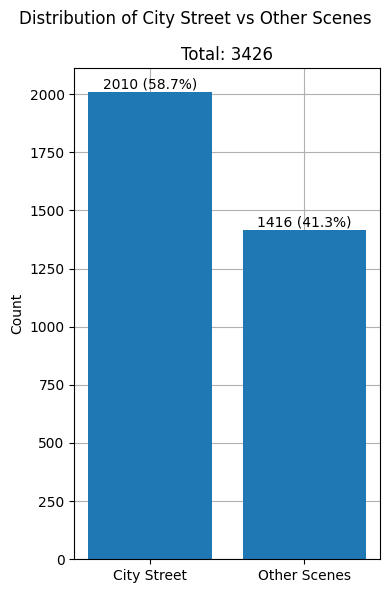

In [7]:
city_street_count = 0
non_city_street_count = 0

for scene in scene_counts:
    if 'city street' in scene:
        city_street_count += scene_counts[scene]
    else:
        non_city_street_count += scene_counts[scene]

plt.figure(figsize=(4,6))
plt.bar(['City Street', 'Other Scenes'], [city_street_count, non_city_street_count], zorder=2)
plt.suptitle('Distribution of City Street vs Other Scenes')
plt.title(f'Total: {city_street_count + non_city_street_count}')
plt.grid(True, zorder=1)
plt.ylabel('Count')

total = city_street_count + non_city_street_count
for i, v in enumerate([city_street_count, non_city_street_count]):
    percentage = (v / total) * 100
    plt.text(i, v, f'{v} ({percentage:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

When taking a global view on either a city environment or non-city environment, we can see that there is a smaller imbalance between the two. 

There seem to be enough samples to represent both regimes, however it will be important to keep in mind that we can only make assumptions with confidence over `residential` and `highway` scenes when it comes to non-city street environments (Other Scenes in the plot).